In [459]:
# imports for the rest of the assignment
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.autograd import backward, Variable
import torch.optim as optim

## Loading Files

In [412]:
# File names
map_1_file = "./data/map_1.dat"
map_2_file = "./data/map_2.dat"
map_3_file = "./data/map_3.dat"
map_4_file = "./data/map_4.dat"

enemies_1_file = "./data/enemies_1.dat"
enemies_2_file = "./data/enemies_2.dat"
enemies_3_file = "./data/enemies_3.dat"

maps = []
for map_file in [map_1_file, map_2_file, map_3_file, map_4_file]:
    map_data = []
    with open(map_file, 'r') as file:
        for line in file:
            map_data.append(list(map(int, line.split())))
    maps.append(map_data)
    
enemies = []
for enemies_file in [enemies_1_file, enemies_2_file, enemies_3_file]:
    enemies_data = []
    with open(enemies_file, 'r') as file:
        for line in file:
            ey, ex, et = list(map(int, line.split()))
            enemies_data.append([ey - 1, ex - 1, et])
            
    enemies.append(enemies_data)
print(len(maps[0]), len(maps[0][0]))
      
      

32 32


In [17]:
# Algorithm 1 described in task sheet
def find_intersects(i, j, ni, nj):
    deltai = abs(ni - i)
    deltaj = abs(nj - j)
    n = deltai + deltaj + 1
    di = 1 if ni > i else -1
    dj = 1 if nj > j else -1
    epsilon = deltai - deltaj
    deltai = 2 * deltai
    deltaj = 2 * deltaj
    
    tiles = []
    #find interesects
    while n > 0:
        tiles.append((i, j))
        # The difference in x direction is greater than y
        if epsilon > 0:
            i += di
            epsilon -= deltaj
            n -= 1
        # y difference greater than x
        elif epsilon < 0:
            j += dj
            epsilon += deltai
            n -= 1
        # equal difference in x and y
        elif epsilon == 0:
            i += di
            j += dj
            epsilon += deltai - deltaj
            n -= 2
        
    return tiles


In [18]:
def next_state(x, y, action, level):
    energy = 0
    # jump
    if action == 1:
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if still air under
            if level[y+1][x] == 1:
                y += 1
            
        # if footing is solid
        else:
            # if not solid above
            if level[y-1][x] != 2:
                y -= 1
                # if still not solid above
                if level[y-1][x] != 2:
                    y -= 1
            
            energy = -5
            
    # go left if not solid
    elif action == 0:
        energy = -1
        if level[y][x-1] != 2:
            x -= 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x-1] != 2:
                    x -= 1
                if level[y+1][x] == 1:
                    y += 1
    
    # go right if not solid
    elif action == 2:
        energy = -1
        if level[y][x+1] != 2:
            x += 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x+1] != 2:
                    x += 1
                if level[y+1][x] == 1:
                    y += 1
    
    return ((x, y), energy)
            

# Task 2

Dynamic Programming using Iterative Policy Evaluation

In [31]:
def level2(level, mms, pmm):
    # value function height, width, action space
    v_func = np.zeros((len(level), len(level[0])))
    delta = 1
    theta = 0.00000000001
    
    iterations = 0
    
    while(delta >= theta):
        delta = 0.0
        for row in range(len(level[0]) - 1, 0, -1):
            for col in range(len(level) - 1):
                if level[col][row] == 2:
                    continue
                    
                # goal
                if col == 1 and row == 30:
                    continue
                
                v = v_func[col][row]
                      
                values = []
                energies = []
                
                # find values and energy for all next states
                for a in [0, 1, 2]:
                    (nx, ny), e = next_state(row, col, a, level)
                    values.append(v_func[ny, nx] + e)
                    energies.append(e)
                      
                expected = max(values)
                energy = energies[values.index(expected)]
                
                # check if an mm is at the position
                for (my, mx, _) in mms:
                    if col == my and row == mx:
                        # update the value based on p of going back to start
                        expected = (1 - pmm) * expected + pmm * (v_func[30, 1] + energy)
                    
                v_func[col, row] = expected
                delta = max(delta, abs(v - v_func[col, row]))
                
        iterations += 1
                      
    return v_func, iterations

In [32]:
def level2path(vf, level):
    x, y = (1, 30)
    path_x = [x]
    path_y = [y]
    
    while not(x == 30 and y == 1):
        states = []
        values = []
        for a in [0, 1, 2]:
            (nx, ny), _ = next_state(x, y, a, level)
            states.append((nx, ny))
            values.append(vf[ny, nx])
            
        x, y = states[values.index(max(values))]
        path_x.append(x)
        path_y.append(y)
    return path_x, path_y
        

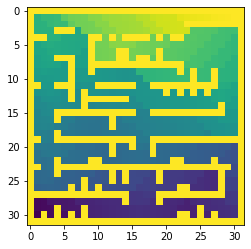

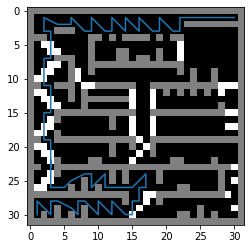

398


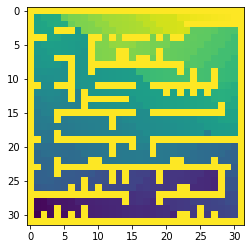

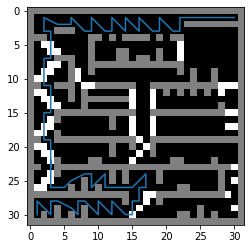

484


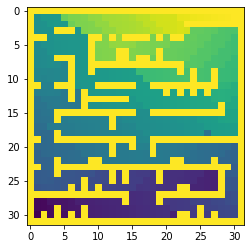

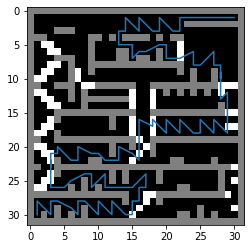

226


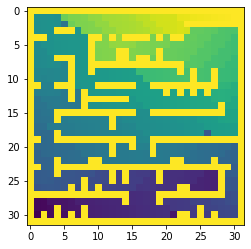

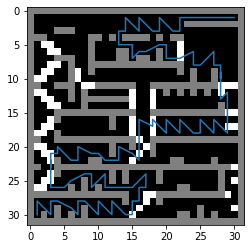

225


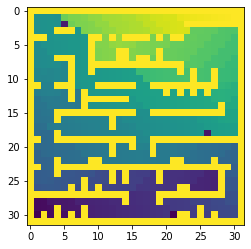

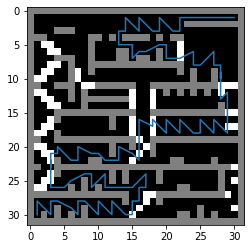

225


In [33]:
for pmm in [0.1, 0.2, 0.3, 0.5, 0.9]:
    level2_vf, level2_iters = level2(maps[0], enemies[0], pmm)
    path_x, path_y = level2path(level2_vf, maps[0])
    plt.imshow(level2_vf)
    plt.show()
    plt.imshow(maps[0], cmap="gray")
    plt.plot(path_x, path_y)
    plt.show()
    print(level2_iters)

# Task 3

In [501]:
def init_mms(mms, level):
    for i, (mmy, mmx) in enumerate(mms):
        right = mmx
        while(level[mmy][right+1] != 2 and level[mmy+1][right+1] != 1):
            right += 1
            
        mms[i] = (mmy, random.randint(mmx, right))             
    return mms    
        

In [493]:
def mms_next_state(mms, level):
    new_mms = []
    if not mms:
        raise ValueError("The list of mms is empty")
    for mmy, mmx in mms:
        options = []
        if level[mmy][mmx-1] != 2 and level[mmy+1][mmx-1] != 1:
            options.append(mmx-1)
        if level[mmy][mmx+1] != 2 and level[mmy+1][mmx+1] != 1:
            options.append(mmx+1)
        
        if not options:
            new_mms.append((mmy, mmx))
        else:
            new_mms.append((mmy, np.random.choice(options)))
    return new_mms


In [105]:
def select_dictionary_action(Q, s, epsilon=0.1):
    # explorative move
    if random.random() < epsilon:
        return random.randrange(0, 3)
    # exploitative move
    max_value = max(Q[s])
    options = [i for i, a in enumerate(Q[s]) if a == max_value]
    return np.random.choice(options)


In [498]:
# Sarsa for estimating Q approximately q
def level3_TD(enemies, level=maps[1], episodes=20000, alpha=0.3, epsilon=0.1, max_steps=100000):
    Q = {} # x, y, mm
    
    path_xs = []
    path_ys = []
    total_energy = 0
    
    mms = [(y, x) for y, x, _ in enemies]
    
    for e in tqdm(range(episodes)):
        x, y = (1, 30) # S
        mms = init_mms(mms, level) # x coordinate of mm
        s = str(x) + " " + str(y)
        Q[s] = [0.0, 0.0, 0.0]
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = next_state(x, y, a, level)
            nmms = mms_next_state(mms , level)
            
            # find path of hubert this timestep
            intersections = find_intersects(x, y, nx, ny)
            for (ix, iy) in intersections:
                for mmy, mmx in mms:
                    if ix == mmx and iy == mmy:
                        nx, ny = (1, 30) # back to start
                        break
            
            ns = str(nx) + " " + str(ny)
            
            if 16 < ny < 20:
                ns += " " + str(mms[0][1])
                
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # are we in the terminal state?
            if nx == 30 and ny == 2:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R = energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, mms, s, a = (nx, ny, nmms, ns, na)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
    
    return Q, path_xs, path_ys, total_energy

In [499]:
level_3Q, level3_path_xs, level3_path_ys, level3_te = level3_TD(enemies[1], episodes=50000, epsilon=0)



100%|████████████████████████████████████| 50000/50000 [06:17<00:00, 132.49it/s]


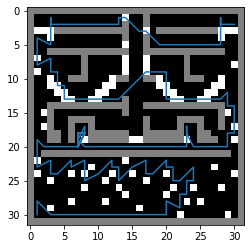

610


In [500]:
plt.imshow(maps[1], cmap="gray")
plt.plot(level3_path_xs, level3_path_ys)
plt.show()
print(level3_te)

# Level 4

Dictionary State Space using only the local features of the window 

In [7]:
def fans_in_view(x, y, r, fans):
    # fans in view
    fans_in_view = ""
    for dx in range(-r, r + 1):
        for dy in range(-r, r + 1):
            if dx == 0 and dy == 0:
                continue
            
            for fx, fy in fans:
                if x + dx == fx and y + dy == fy:
                    fans_in_view += " " + str(dx) + " " + str(dy)
                    
    return fans_in_view.strip()

In [450]:
def fans_next_state(fans, x, y, level):
    new_fans = []
    if not fans:
        raise ValueError("The list of fans is empty")
    for fy, fx in fans:
        options = []
        if y != fy:
            if level[fy][fx-1] != 2 and level[fy+1][fx-1] != 1:
                options.append(fx-1)
            if level[fy][fx+1] != 2 and level[fy+1][fx+1] != 1:
                options.append(fx+1)
        else:
            if x < fx:
                if level[fy][fx-1] != 2 and level[fy+1][fx-1] != 1:
                    options.append(fx-1)
            else:
                if level[fy][fx+1] != 2 and level[fy+1][fx+1] != 1:
                    options.append(fx+1)
        
        if not options:
            new_fans.append((fy, fx))
        else:
            new_fans.append((fy, np.random.choice(options)))
    return new_fans

In [527]:
# Sarsa for estimating Q approximately q
def level4_TD(enemies, radius, episodes=20000, alpha=0.5, epsilon=0.1, level=maps[2], max_steps=100000):
    Q = {} # x, y, fans
    
    path_xs = []
    path_ys = []
    total_energy = 0
    
    fans = [(y, x) for y, x, _ in enemies]
    
    for e in tqdm(range(episodes)):
        x, y = (1, 30) # S
        # fans
        fans = init_mms(fans, maps[3])
                
        fans_seen = fans_in_view(x, y, radius, fans)
        s = str(x) + " " + str(y) + " " + fans_seen
        if not s in Q:
            Q[s] = [0.0, 0.0, 0.0]
            
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0    
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = next_state(x, y, a, level)
            # new fan locations
            nfans = fans_next_state(fans, nx, ny, level)
            fans_seen = fans_in_view(x, y, radius, nfans)
            ns = str(nx) + " " + str(ny) + str(fans_seen)
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # have they intersected?
            # find path of hubert this timestep
            intersections = find_intersects(x, y, nx, ny)
            
            for (ix, iy) in intersections:
                for nfx, nfy in nfans:
                    if ix == nfx and iy == nfy:
                        R -=  np.random.uniform(20, 100)# back to start
            
            # are we in the terminal state?
            if nx == 30 and ny == 1:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R = energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, s, a, fans = (nx, ny, ns, na, nfans)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
    
    return Q, path_xs, path_ys, total_energy



In [528]:
level_4Q, level4_path_xs, level4_path_ys, te = level4_TD(enemies[2], 4, epsilon=0)


100%|████████████████████████████████████| 20000/20000 [02:50<00:00, 117.20it/s]


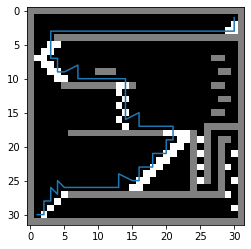

80 142


In [529]:
plt.imshow(maps[2], cmap="gray")
plt.plot(level4_path_xs, level4_path_ys)
plt.show()
print(len(level4_path_xs), te)

# Level 5

Solve using both Q-learning tabularly and then solve using Function Approximation

In [167]:
def level5_next_state(x, y, action, level):
    energy = 0
    # jump
    if action == 1:
        if level[y+1][x] == 1:
            # if footing is air
            if random.randrange(0, 3) == 0:
                if level[y-1][x] != 2:
                    y -= 1
                energy = -3
            else:
                y += 1
                # if still air under
                if level[y+1][x] == 1:
                    y += 1
            
        # if footing is solid
        else:
            # if not solid above
            if level[y-1][x] != 2:
                y -= 1
                # if still not solid above
                if level[y-1][x] != 2:
                    y -= 1
            
            energy = -5
            
    # go left if not solid
    elif action == 0:
        energy = -1
        if level[y][x-1] != 2:
            x -= 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x-1] != 2:
                    x -= 1
                if level[y+1][x] == 1:
                    y += 1
    
    # go right if not solid
    elif action == 2:
        energy = -1
        if level[y][x+1] != 2:
            x += 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x+1] != 2:
                    x += 1
                if level[y+1][x] == 1:
                    y += 1
    
    return ((x, y), energy)

In [53]:
def get_local_features(x, y, r, level):
    features = []
    for dy in range(-r, r + 1):
        for dx in range(-r, r + 1):
            features.append(level[y+dy][x+dx])
    return features

In [55]:
def pad_level(l, r):
    level = [[-1 for _ in range(len(l[0]) + 2 * r)] for _ in range(len(l) + 2 * r)]
    for y in range(len(l)):
        for x in range(len(l[0])):
            level[y + r][x + r] = l[y][x]
    
    return level


Solution using action-value function

In [370]:
# Sarsa for estimating Q approximately q
def level5_TD(radius, level=maps[3], episodes=20000, alpha=0.3, epsilon=0.1, max_steps=100000):
    Q = {} # local features
    
    path_xs = []
    path_ys = []
    best_xs = []
    best_ys = []
    best_energy = float("inf")
    final_energy = 0
    
    level = pad_level(level, radius)
    
    for e in tqdm(range(episodes)):
        x, y = (1 + radius, 30 + radius) # S
        s = "-".join(str(_) for _ in get_local_features(x, y, radius, level))
        if not s in Q:
            Q[s] = [0.0, 0.0, 0.0]
            
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0    
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = level5_next_state(x, y, a, level)
            ns = "-".join(str(_) for _ in get_local_features(nx, ny, radius, level))
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # are we in the terminal state?
            if nx == 30 + radius and ny == 1 + radius:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R = energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, s, a = (nx, ny, ns, na)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        if current_energy < best_energy:
            best_xs = xs
            best_ys = ys
            best_energy = current_energy
        final_energy = current_energy
    
    return Q, path_xs, path_ys, best_xs, best_ys, final_energy



In [371]:
l5Q_td, l5_path_xs_td, l5_path_ys, l5_best_xs, l5_best_ys, l5td_te = level5_TD(4, epsilon=0)


100%|████████████████████████████████████| 20000/20000 [00:35<00:00, 563.25it/s]


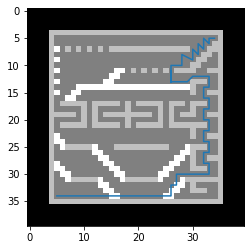

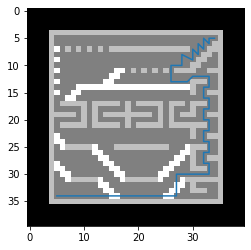

77 157


In [372]:
plt.imshow(pad_level(maps[3], 4), cmap="gray")
plt.plot(l5_path_xs_td, l5_path_ys)
plt.show()
plt.imshow(pad_level(maps[3], 4), cmap="gray")
plt.plot(l5_best_xs, l5_best_ys)
plt.show()
print(len(l5_path_xs_td), l5td_te)

Solution using PyTorch and function approximation

In [300]:
class Policy(nn.Module):
    """PyTorch solution for function approximation,
    input """
    def __init__(self, local_window=9):
        super().__init__()
        
        self.fc1 = nn.Linear(local_window**2, 64)
        self.fc2 = nn.Linear(64, 3)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.softmax(self.fc2(out))
        return out


In [355]:
def select_policy_action(policy, s, epsilon=0.1):
    s_tensor = torch.tensor(s).type(torch.FloatTensor)
    a_value = policy(s_tensor)
    a = torch.argmax(a_value)
    # explorative move
    if random.random() < epsilon:
        return random.randrange(0, 3), a_value
    # exploitative move
    return a, a_value



In [373]:
# Semi-gradient Sarsa with function approximation using neural network
def level5_func_approx(radius, episodes=20000, gamma=0.99, epsilons=[0.9, 0.5, 0.1, 0.01], max_steps=100000):
    
    policy = Policy(radius * 2 + 1)
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    gamma = 1.0
    
    path_xs = []
    path_ys = []
    total_energy = 0
    epsilon, e_index = (epsilons[0], 0)
    
    # fix to be parameter
    level = pad_level(maps[3], radius)
    
    for e in tqdm(range(episodes)):
        x, y = (1 + radius, 30 + radius) # S
        s = get_local_features(x, y, radius, level)
        
        # select action from policy
        a, a_v = select_policy_action(policy, s, epsilon)
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        """
        if e != 0 and e % (episodes // len(epsilons)) == 0:
            epsilon = epsilons[e_index+1]
            e_index += 1
            print(e, epsilon)
        """
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), R = level5_next_state(x, y, a, level)
            
            # are we in the terminal state?
            if nx == 30 + radius and ny == 1 + radius:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                final_loss = torch.tensor(-(R - a_v[a]), requires_grad=True)
                final_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                break
            
            # Choose action A' as a function of  q(S', *, w)
            ns = get_local_features(nx, ny, radius, level)
            na, na_v = select_policy_action(policy, ns, epsilon)
            
            # Update X, S and A
            loss = -(R + gamma * na_v[na] - a_v[a])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            x, y, s, a, a_v = (nx, ny, ns, na, na_v.detach())
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
        
        if e % 20 == 0:
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
    
    return path_xs, path_ys, total_energy



  0%|                                                   | 0/200 [00:00<?, ?it/s]

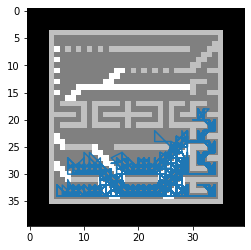

  8%|███▍                                    | 17/200 [05:47<1:02:16, 20.42s/it]


KeyboardInterrupt: 

In [374]:
level5_path_xs, level5_path_ys, level5_te = level5_func_approx(4, episodes=200, epsilons=[0.9, 0.1, 0.01])


# Level 6

In [698]:
def loss_fn(r, x):
    return -(r*torch.log(x) + (1-r) * torch.log(1 - x))


In [732]:
# Semi-gradient Sarsa with function approximation using neural network
def level6(enemies, radius, level, e0=0, dE=0, episodes=5000, gamma=0.99, epsilon=0.01):
    
    policy = Policy(radius * 2 + 1)
    optimizer = optim.Adam(policy.parameters())
    gamma = 1.0
    
    path_xs = []
    path_ys = []
    y_peak_total = len(level)+radius
    peaks = 0
    
    # fix to be parameter
    level = pad_level(level, radius)
    
    for e in tqdm(range(episodes)):
        x, y = (1 + radius, 30 + radius) # S
        s = get_local_features(x, y, radius, level)
        energy_budget = e0
        y_peak = len(level)+radius
        
        # select action from policy
        a, value_a = select_policy_action(policy, s, epsilon)
        
        # for trajectory plotting
        xs = []
        ys = []
        
        # testing for different rewards
        last_pos = [(x, y)]
        last_ys = [y for _ in range(5)]
        
        while True:
            xs.append(x)
            ys.append(y)
            
            # Observe R, S'. S' described as = n+value (for new)
            R = 0
            (nx, ny), energy = level5_next_state(x, y, a, level)
            energy_budget += energy
            
            # ways to hand out reward
            if ny < y_peak:
                y_peak = ny
                energy_budget += dE
                R = 1
            
            if ny == radius + 1:
                R = 1
            # makes him go straight up before exploring?
            if ny < np.mean(last_ys):
                R = 1
            """
            # good for jumping
            if ny < np.average(last_ys):
                R = 1
            """
            
            last_ys.pop(0)
            last_ys.append(ny)
            
            # Rewards exploration
            if (nx, ny) not in last_pos:
                last_pos.append((nx, ny))
                R = 1
                
            # are we in the terminal state?
            if energy_budget < 0:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                final_loss = loss_fn(R, value_a[a].clone().detach().requires_grad_(True))
                final_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                break
            
            # Choose action A' as a function of  q(S', w)
            ns = get_local_features(nx, ny, radius, level)
            na, value_na = select_policy_action(policy, ns, epsilon)
            
            # Update X, S and A
            #loss = -(R + gamma * na_v[na] - a_v[a])
            
            # loss function to use with softmax and R either 0 or 1
            # give reward for going to a new state, or just move at all
            # punish for not getting going upward, and reward for going upward
            # dont punish for using energy (wont jump probably)
            loss = loss_fn(R, value_na[na])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            x, y, s, a, value_a = (nx, ny, ns, na, value_na.detach())
            
        path_xs = xs
        path_ys = ys
        
        if y_peak - radius == 0:
            peaks += 1
        
        if y_peak - radius < y_peak_total:
            y_peak_total = y_peak - radius
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
        
        if e % 400 == 0:
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
    
    return policy, y_peak_total, peaks, path_xs, path_ys


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

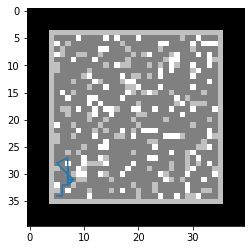

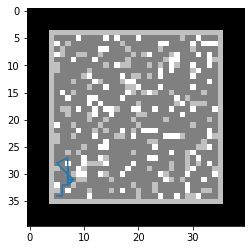

  0%|                                          | 3/5000 [00:00<07:26, 11.20it/s]

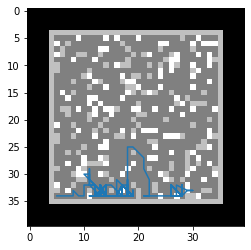

  0%|                                         | 11/5000 [00:00<06:57, 11.94it/s]

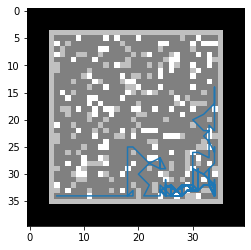

  8%|███▏                                    | 400/5000 [00:22<03:58, 19.31it/s]

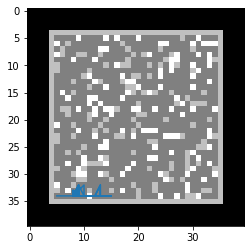

 14%|█████▌                                  | 701/5000 [00:38<03:56, 18.20it/s]


KeyboardInterrupt: 

In [734]:
level6_policy, level_6_peak, peaks, level6_path_xs, level6_path_ys = level6(None, 4, create_custom_map(32, 32), e0=400, dE=50, episodes=5000)
print(level_6_peak, peaks)

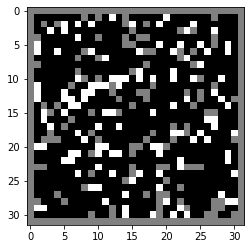

In [670]:
def create_custom_map(x, y):
    custom_map = [[2] + [1 for _ in range(x-2)] + [2] for _ in range(y)]
    custom_map[0] = [2 for _ in range(x)]
    custom_map[31] = [2 for _ in range(x)]
    for i in range(1, 31):
        for j in range(1, 31):
            custom_map[i][j] = np.random.choice([1, 1, 1, 1, 1, 1, 2, 3])
    custom_map[y-2][1] = 1
    return custom_map

plt.imshow(create_custom_map(32, 32), cmap="gray")
plt.show()